In [72]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [51]:
def create_donut_charts(dataframes, column_names, titles=None):
    if titles is None:
        titles = column_names
        
    num_bar_charts = len(dataframes)
    fig, axs = plt.subplots(1, num_bar_charts, figsize=(7.5 * num_bar_charts, 6))

    for i, df in enumerate(dataframes):
        values = df[column_names[i]]
        labels = [*df.index]
        print(values)
        total = sum(values)
        axs[i].pie(
            values,
            labels=labels,
            # colors=colors,
            autopct=lambda p: f"{p:.0f}% ({p * total / 100:.0f})" if p > 0 else "0",
            startangle=140,
            wedgeprops=dict(width=0.25, edgecolor="w", linewidth=0.25),
            textprops=dict(color="black", fontsize=10),
        )
        axs[i].set_title(titles[i])
        axs[i].axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()
    # plt.show()
    return fig

In [20]:
outpath = Path('results/wallet_analysis')
outpath.mkdir(exist_ok=True)

wallet_df = pd.read_csv(Path('data/stETH_token_distribution.csv'))
wallet_df.loc[wallet_df.type.isna(), 'type'] = 'Private'

In [21]:
wallet_df.type.value_counts()

Private     1037
Contract     152
Custody       11
CEX            8
Name: type, dtype: int64

In [39]:
wallet_type_summary = wallet_df.groupby('type').sum(numeric_only=True)
wallet_type_summary['wallet_count'] = wallet_df.groupby('type').count()['address']
wallet_type_summary

,stETH,wstETH,total,wallet_count
type,,,,
CEX,1.091492e+05,3.834860e+03,1.136502e+05,8
Contract,2.023537e+06,2.175870e+06,4.577356e+06,152
Custody,2.853018e+04,4.238680e+04,7.827957e+04,11
Private,2.526655e+06,1.056745e+06,3.766957e+06,1037


type
CEX            8
Contract     152
Custody       11
Private     1037
Name: wallet_count, dtype: int64
type
CEX         1.136502e+05
Contract    4.577356e+06
Custody     7.827957e+04
Private     3.766957e+06
Name: total, dtype: float64


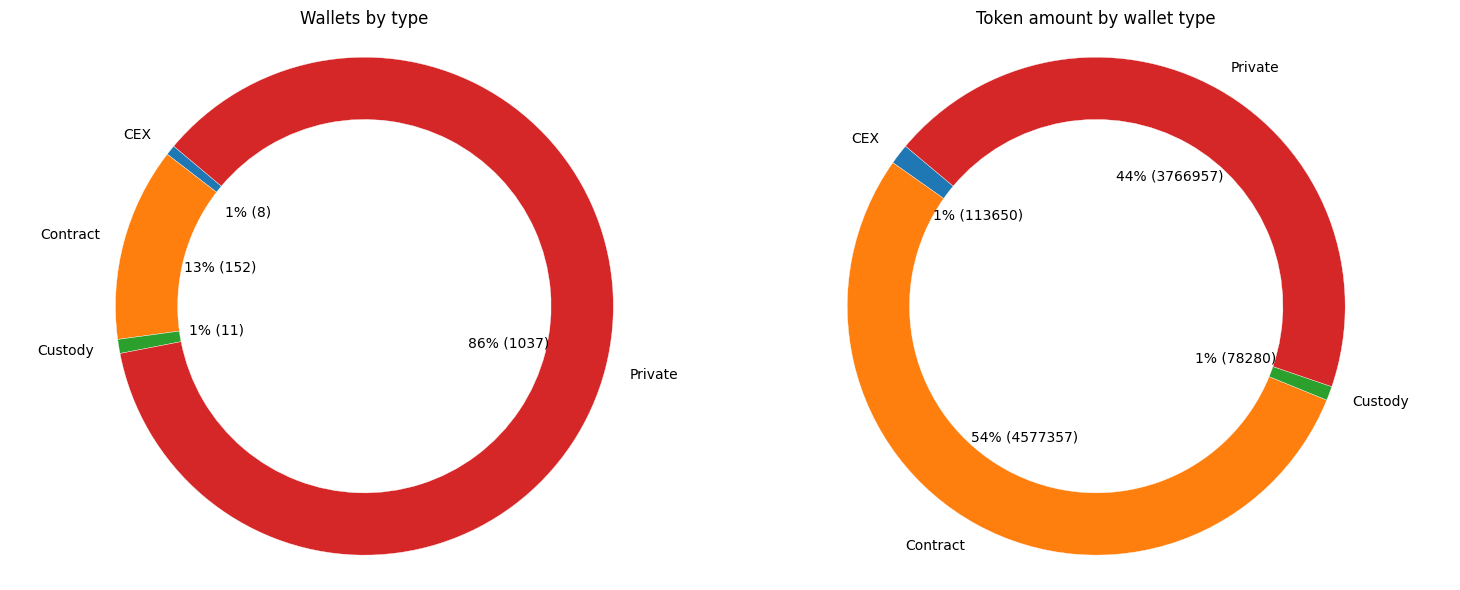

In [54]:
fig = create_donut_charts([wallet_type_summary, wallet_type_summary], ['wallet_count', 'total'], ['Wallets by type', 'Token amount by wallet type']);
fig.savefig(outpath.joinpath('wallet_type_piechart.png'))

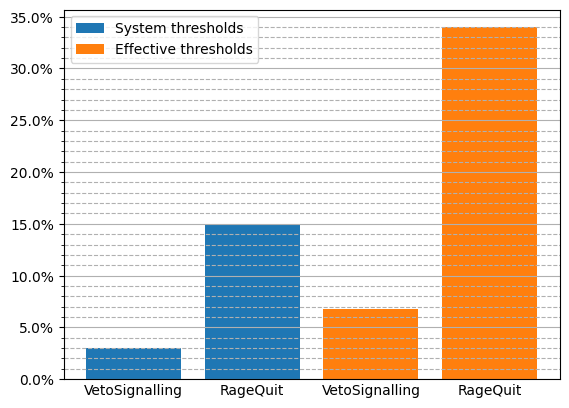

In [81]:
active_percent = wallet_type_summary['total']['Private'] / wallet_type_summary['total'].sum()

default_percents = np.array([3, 15])
plt.bar([0,1], default_percents, label='System thresholds')
plt.bar([2,3], default_percents / active_percent, label='Effective thresholds')
plt.xticks([0,1,2,3], labels=['VetoSignalling', 'RageQuit', 'VetoSignalling', 'RageQuit'])
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))
plt.gca().tick_params(axis=u'x', which=u'both',length=0)
plt.grid(True, axis='y')
plt.gca().grid(True, axis='y', which='minor', linestyle='--')
plt.legend()
plt.savefig(outpath.joinpath('effective_threshold_barchart.png'))

In [112]:
wallet_df['share'] = wallet_df.total / wallet_df.total.sum()
share_df = wallet_df[wallet_df.type == 'Private'].sort_values(by='total', ascending=False).copy()
share_df

,address,stETH,wstETH,total,label,type,protocol_type,share
3,0x98078db053902644191f93988341e31289e1c8fe,453283.812900,0.00000,453283.812900,Private Transactions Miner [0x6b764a],Private,NaN,0.053101
5,0xc329400492c6ff2438472d4651ad17389fcb843a,0.000000,210603.20510,247184.981800,clonmel.eth [0x9d91ae],Private,NaN,0.028957
8,0x48d62ed012e327faacb9c8d2a56330e215da0575,0.000000,105695.13730,124054.382600,EIP 1559 User [0x5a1f9d],Private,NaN,0.014533
9,0x3c22ec75ea5d745c78fc84762f7f1e6d82a2c5bf,9543.968864,80790.22584,104367.456900,pewpews.eth [0xa626bd],Private,NaN,0.012226
10,0x43594da5d6a03b2137a04df5685805c676def7cb,96252.516950,0.00000,96252.516950,High Balance [0x8d249e],Private,NaN,0.011276
...,...,...,...,...,...,...,...,...
1203,0x3fa930a14c9a35b6d4b3babaae395384eadd0d1f,510.591493,0.00000,510.591493,NaN,Private,NaN,0.000060
1204,0xc4652535aad91abbb4cc90f3f474e9f765003e05,509.909753,0.00000,509.909753,NaN,Private,NaN,0.000060
1205,0xa2694887f13a7bfee00824ba02b38ae848779136,509.548730,0.00000,509.548730,NaN,Private,NaN,0.000060
1206,0x3f1131d2107c6fd8d1f7f3808dfccefe5afcf6fe,509.286951,0.00000,509.286951,NaN,Private,NaN,0.000060


In [130]:
print('Only the largest wallet can overcome the VS threshold')
count0 = len(share_df) - 1
print(f'{count0} other wallets can join the largest wallet')
count1 = np.sum((share_df.drop([3,5]).share + share_df.loc[5].share) >= 0.03)
print(f'{count1} smaller wallets can overcome the VS threshold with the second largest wallet')
count2 = np.sum((share_df.drop([3,5,8]).share + share_df.loc[8].share) >= 0.03)
print(f'{count2} smaller wallets can overcome the VS threshold with the third largest wallet')
print(f'So {count0 + count1 + count2} total pairs, but they contain either the first or the second largest wallets')

Only the largest wallet can overcome the VS threshold
1036 other wallets can join the largest wallet
52 smaller wallets can overcome the VS threshold with the second largest wallet
0 smaller wallets can overcome the VS threshold with the third largest wallet
So 1088 total pairs, but they contain either the first or the second largest wallets


### Todo count triplets in the same manner. Meaning count triplets with the second largest wallet and wallets not in the count1, the third largest wallet

In [156]:
share_df_d = share_df.drop([3,5])
mask = (share_df_d.share + share_df.loc[5].share) < 0.03

count3 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[99].share + share_df_d[mask].drop([99]).share) >= 0.03)
count4 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[100].share + share_df_d[mask].drop([99,100]).share) >= 0.03)
count5 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[101].share + share_df_d[mask].drop([99,100, 101]).share) >= 0.03)
count6 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[105].share + share_df_d[mask].drop([99,100, 101,105]).share) >= 0.03)
count7 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[106].share + share_df_d[mask].drop([99,100, 101,105,106]).share) >= 0.03)
count8 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[107].share + share_df_d[mask].drop([99,100, 101,105,106,107]).share) >= 0.03)
count9 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[109].share + share_df_d[mask].drop([99,100, 101,105,106,107,109]).share) >= 0.03)
count10 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[111].share + share_df_d[mask].drop([99,100, 101,105,106,107,109,111]).share) >= 0.03)
count11 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[113].share + share_df_d[mask].drop([99,100, 101,105,106,107,109,111,113]).share) >= 0.03)
count12 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[115].share + share_df_d[mask].drop([99,100, 101,105,106,107,109,111,113,115]).share) >= 0.03)
print(count3, count4, count5, count6, count7, count8, count9, count10, count11, count12)

982 981 980 634 361 350 321 290 245 232


In [149]:
share_df_d[mask].head(10)

,address,stETH,wstETH,total,label,type,protocol_type,share
99,0x1a5213554ac2f7056c554fb19416ff9738e165ba,8846.902577,0.000000,8846.902577,haos.eth [0x1a5213],Private,NaN,0.001036
100,0x98ec0508e134dfee2992e42577696625768be437,8757.369407,0.000000,8757.369407,Token Millionaire [0x98ec05],Private,NaN,0.001026
101,0xa5d223c176daab154a3134369d1c0478c5e6fecf,0.000000,7305.219814,8574.136496,10248.eth* [0xa5d223],Private,NaN,0.001004
105,0xb3668730e4a8abe282a6d471c75baf75557ffff3,0.000000,6885.493147,8081.503306,Token Millionaire [0x4992c5],Private,NaN,0.000947
106,0x46cd2870894a9a7d5eedbb40997d994fa8a058df,7658.563187,0.000000,7658.563187,Token Millionaire [0x46cd28],Private,NaN,0.000897
107,0xfc09d8c9a63670702c2de876ff95608ab971dcd6,7621.633895,0.000000,7621.633895,Token Millionaire [0xfc09d8],Private,NaN,0.000893
109,0x4a240f0ee138697726c8a3e43efe6ac3593432cb,0.000000,6412.794919,7526.697396,Gnosis Safe MultiSig,Private,NaN,0.000882
111,0x0685c5aed38f038d984e8dc7dc8ad8783f166f35,0.000000,6300.000000,7394.310000,Token Millionaire,Private,NaN,0.000866
113,0xa3726bedfd1a8aa696b9b4581277240028c4314b,0.000000,6121.661852,7184.994516,Token Millionaire,Private,NaN,0.000842
115,0x720d8790666bd40b9ca289cbe73cb1334f0ae7e3,7101.672500,0.000000,7101.672500,Gnosis Safe MultiSig,Private,NaN,0.000832


So there are much more triplets that can put the system into VetoSignalling. TODO exaustive counting